# Let's try some learnning models

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,KFold,cross_val_score,ShuffleSplit
#models
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
#evaluation
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('googleplaystore.csv')
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


# Some explain of data fields
**App** - application name<br><br>
**Category** - general category of the app<br><br>
**Rating** - star rate(from 0 to 5)<br><br>
**Reviews** - number of Reviews<br><br>
**Size** - the size of the app in mb<br><br>
**Installs** - number of install(approximately)<br><br>
**Type** - is the app in free or not(paid)<br><br>
**Price** - the price in of the app<br><br>
**Content Rating** - Target Audience<br><br>
**Genres** - spesific genre(category) of the app<br><br>
**Last Updated** - date of the last update<br><br>
**Current Ver** - current version of the app<br><br>
**Android Ver** - minmum android version that the app support<br><br>

# Prepare the Data

In [4]:
#SUCCESS_RATE = 4.5
#MIN_REVIEWS_NUMBER = 1000
NUM_INSTALL_TO_SUCCESS_STATE = 5000000
NUM_INSTALL_TO_GOOD_RATE = 20000
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [5]:
df.Installs = df.Installs.str.replace(",", "")
df.Installs = df.Installs.str.replace("+", "")
df = df[df["Installs"]!='Free']
df["Installs"] = pd.to_numeric(df["Installs"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10840 entries, 0 to 10840
Data columns (total 13 columns):
App               10840 non-null object
Category          10840 non-null object
Rating            9366 non-null float64
Reviews           10840 non-null object
Size              10840 non-null object
Installs          10840 non-null int64
Type              10839 non-null object
Price             10840 non-null object
Content Rating    10840 non-null object
Genres            10840 non-null object
Last Updated      10840 non-null object
Current Ver       10832 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 1.2+ MB


In [6]:
milions = df[df['Size'].str.contains('M')]
ks = df[df['Size'].str.contains('k')]
other = df[((df['Size'].str.contains('k'))|df['Size'].str.contains('M'))==False]
milions.Size = df.Size.str.replace("M", "")
milions["Size"] = pd.to_numeric(milions["Installs"])
ks["Size"] = pd.to_numeric(ks["Installs"])
df = pd.concat([milions,ks])
other['Size'] = df['Size'].median()
df = pd.concat([other,df])
df

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
2544,Facebook,SOCIAL,4.1,78158306,100000.0,1000000000,Free,0,Teen,Social,"August 3, 2018",Varies with device,Varies with device
3943,Facebook,SOCIAL,4.1,78128208,100000.0,1000000000,Free,0,Teen,Social,"August 3, 2018",Varies with device,Varies with device


In [43]:
df = df.dropna(axis=0, subset=['Type'])#delete one row
df.isna().sum()

App                  0
Category             0
Rating            1473
Reviews              0
Size                 0
Installs             0
Type                 0
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64

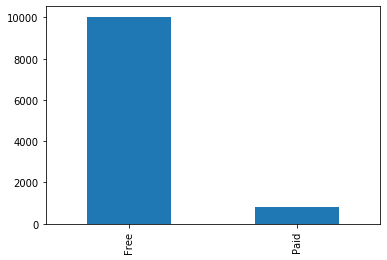

In [44]:
df['Type'].value_counts().plot(kind='bar')

In [45]:
print(df['Type'].unique())
df.loc[df['Type']=='Free','Type']=0
df.loc[df['Type']=='Paid','Type']=1

['Free' 'Paid']


In [46]:
df.Category = pd.Categorical(df.Category)
df['Category_code'] = df.Category.cat.codes

In [47]:
df['success'] = 0
df.loc[df['Installs']>=NUM_INSTALL_TO_GOOD_RATE,'success']=1
df.loc[df['Installs']>=NUM_INSTALL_TO_SUCCESS_STATE,'success']=2
df.loc[df['Installs']<NUM_INSTALL_TO_GOOD_RATE ,'success']=0
df

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Category_code,success
37,Floor Plan Creator,ART_AND_DESIGN,4.1,36639,100000.0,5000000,0,0,Everyone,Art & Design,"July 14, 2018",Varies with device,2.3.3 and up,0,2
42,Textgram - write on photos,ART_AND_DESIGN,4.4,295221,100000.0,10000000,0,0,Everyone,Art & Design,"July 30, 2018",Varies with device,Varies with device,0,2
52,Used Cars and Trucks for Sale,AUTO_AND_VEHICLES,4.6,17057,100000.0,1000000,0,0,Everyone,Auto & Vehicles,"July 30, 2018",Varies with device,Varies with device,1,1
67,Ulysse Speedometer,AUTO_AND_VEHICLES,4.3,40211,100000.0,5000000,0,0,Everyone,Auto & Vehicles,"July 30, 2018",Varies with device,Varies with device,1,2
68,REPUVE,AUTO_AND_VEHICLES,3.9,356,100000.0,100000,0,0,Everyone,Auto & Vehicles,"May 25, 2018",Varies with device,Varies with device,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10763,FP Разбитый дисплей,FAMILY,4.5,922,50000.0,50000,0,0,Everyone,Entertainment,"September 20, 2014",1.1,1.6 and up,11,1
10764,FP Transportation,AUTO_AND_VEHICLES,NaN,1,1.0,1,0,0,Everyone,Auto & Vehicles,"March 9, 2018",10.0.0,4.0 and up,1,0
10798,Word Search Tab 1 FR,FAMILY,NaN,0,50.0,50,1,$1.04,Everyone,Puzzle,"February 6, 2012",1.1,3.0 and up,11,0
10832,FR Tides,WEATHER,3.8,1195,100000.0,100000,0,0,Everyone,Weather,"February 16, 2014",6.0,2.1 and up,32,1


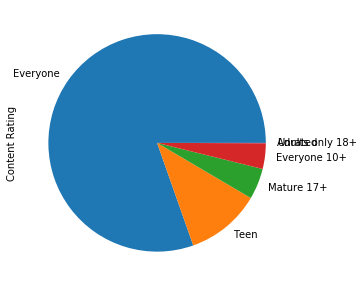

In [48]:
df['Content Rating'].value_counts().plot.pie(y=df['Content Rating'].value_counts(), figsize=(5, 5))

In [49]:
print(df['Content Rating'].unique())
df['Content Rating'] = pd.Categorical(df['Content Rating'])
df['Content Rating'] = df['Content Rating'].cat.codes

['Everyone' 'Teen' 'Mature 17+' 'Everyone 10+' 'Adults only 18+' 'Unrated']


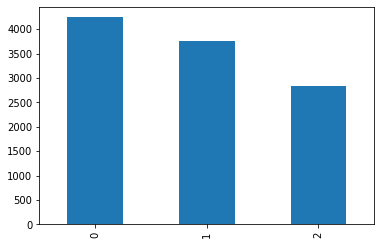

In [50]:
df['success'].value_counts().plot(kind='bar')

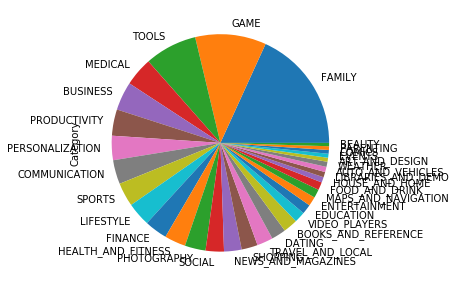

In [51]:
df['Category'].value_counts().plot.pie(y=df['Category'].value_counts(), figsize=(5, 5))

In [52]:
df['Reviews'] = df['Reviews'].astype(str).astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10839 entries, 37 to 10833
Data columns (total 15 columns):
App               10839 non-null object
Category          10839 non-null category
Rating            9366 non-null float64
Reviews           10839 non-null int32
Size              10839 non-null float64
Installs          10839 non-null int64
Type              10839 non-null int64
Price             10839 non-null object
Content Rating    10839 non-null int8
Genres            10839 non-null object
Last Updated      10839 non-null object
Current Ver       10831 non-null object
Android Ver       10837 non-null object
Category_code     10839 non-null int8
success           10839 non-null int64
dtypes: category(1), float64(2), int32(1), int64(3), int8(2), object(6)
memory usage: 1.1+ MB


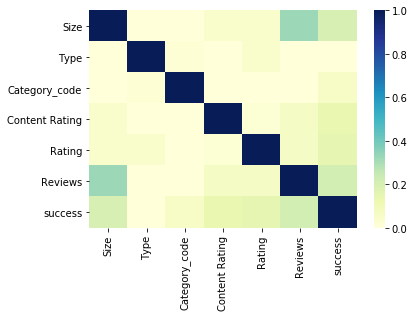

In [53]:
corr = df[['Size','Type','Category_code','Content Rating','Rating','Reviews','success']].corr()
ax = sns.heatmap(corr, vmin=0, vmax=1,cmap="YlGnBu")

# Run All Classification Models

In [54]:
X = df[['Size','Type','Category_code','Content Rating',]]
y = df['success']

## k-Nearest Neighbors

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       842
           1       0.86      0.92      0.89       767
           2       0.87      0.82      0.84       558

    accuracy                           0.92      2167
   macro avg       0.91      0.90      0.91      2167
weighted avg       0.92      0.92      0.92      2167

15


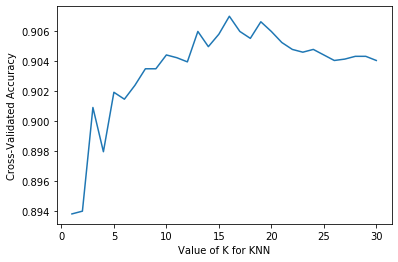

In [55]:
k_scores = []
temp_scores = []
k_range = list(range(1, 31))
mx = 0
kf = KFold(n_splits=5, random_state=42, shuffle=True)
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    for train_index, test_index in kf.split(X):
        X_train, X_test =  X[X.index.isin(train_index)], X[X.index.isin(test_index)]
        y_train, y_test = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
        knn.fit(X_train, y_train)
        temp_scores.append(knn.score(X_test,y_test))
    if(np.mean(temp_scores)>mx):
        mx = np.mean(temp_scores)
        y_pred = knn.predict(X_test)
    k_scores.append(np.mean(temp_scores))
    temp_scores = []
print(classification_report(y_test,y_pred, labels=[0, 1, 2]))
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
print(np.argmax(k_scores))

## Decision Tree

In [56]:
decision_tree = DecisionTreeClassifier(max_depth=4,random_state=42)
kf = KFold(n_splits=5, random_state=42, shuffle=True)
scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test =  X[X.index.isin(train_index)], X[X.index.isin(test_index)]
    y_train, y_test = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
    decision_tree.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_test)
    print(classification_report(y_test,y_pred, labels=[0, 1, 2]))
    print("confusion_matrix:")
    print (confusion_matrix(y_test, y_pred))
    scores.append(decision_tree.score(X_test,y_test))
print("avg-score: ",np.mean(scores))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       824
           1       0.76      1.00      0.86       775
           2       1.00      0.63      0.77       568

    accuracy                           0.89      2167
   macro avg       0.92      0.86      0.87      2167
weighted avg       0.91      0.89      0.88      2167

confusion_matrix:
[[790  34   0]
 [  0 775   0]
 [  0 209 359]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       815
           1       0.74      1.00      0.85       763
           2       1.00      0.59      0.74       590

    accuracy                           0.87      2168
   macro avg       0.91      0.85      0.86      2168
weighted avg       0.91      0.87      0.87      2168

confusion_matrix:
[[786  29   0]
 [  0 763   0]
 [  0 243 347]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       886
 

## Logistic Regression

In [57]:
model = LogisticRegression(random_state=42)
model.fit(X,y)#use "one-vs-rest method"
#there is a second way called "softmax"(or "multinomial") to init the model (when we have muliclasses)
y_pred = model.predict(X)
print(classification_report(y,y_pred, labels=[0, 1, 2]))
print("confusion_matrix:")
print (confusion_matrix(y, y_pred))
print(model.score(X, y))
#the model always pridict as class 2

              precision    recall  f1-score   support

           0       1.00      0.00      0.01      4241
           1       0.00      0.00      0.00      3766
           2       0.26      1.00      0.41      2832

    accuracy                           0.26     10839
   macro avg       0.42      0.33      0.14     10839
weighted avg       0.46      0.26      0.11     10839

confusion_matrix:
[[  14    0 4227]
 [   0    0 3766]
 [   0    0 2832]]
0.2625703478180644


## Neural Network

In [58]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=42)
model.fit(X, y)
y_pred = model.predict(X)
print(classification_report(y,y_pred, labels=[0, 1, 2]))
print("confusion_matrix:\n")
print (confusion_matrix(y, y_pred))
model.score(X, y)

              precision    recall  f1-score   support

           0       0.39      1.00      0.56      4241
           1       0.00      0.00      0.00      3766
           2       0.00      0.00      0.00      2832

    accuracy                           0.39     10839
   macro avg       0.13      0.33      0.19     10839
weighted avg       0.15      0.39      0.22     10839

confusion_matrix:

[[4241    0    0]
 [3766    0    0]
 [2832    0    0]]


0.3912722575883384

## Gaussian Naive Bayes

In [59]:
model = GaussianNB()
kf = KFold(n_splits=5, random_state=42, shuffle=True)
scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test =  X[X.index.isin(train_index)], X[X.index.isin(test_index)]
    y_train, y_test = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred, labels=[0, 1, 2]))
    print("confusion_matrix:")
    print (confusion_matrix(y_test, y_pred))
    scores.append(model.score(X_test,y_test))
print("avg-score: ",np.mean(scores))
#we can see that the most of the mistakes is when its actual 2 and the model pridiction is 1

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       824
           1       0.74      0.90      0.81       775
           2       1.00      0.63      0.77       568

    accuracy                           0.85      2167
   macro avg       0.88      0.83      0.84      2167
weighted avg       0.87      0.85      0.85      2167

confusion_matrix:
[[790  34   0]
 [ 81 694   0]
 [  0 209 359]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       815
           1       0.71      0.88      0.79       763
           2       1.00      0.59      0.74       590

    accuracy                           0.83      2168
   macro avg       0.87      0.81      0.82      2168
weighted avg       0.86      0.83      0.83      2168

confusion_matrix:
[[786  29   0]
 [ 90 673   0]
 [  0 243 347]]
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       886
 

## Random Forest

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model = RandomForestClassifier(max_depth=6, random_state=42)
model.fit(X_train, y_train)
y_pred =  model.predict(X_test)
print("confusion_matrix:")
print (confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred, labels=[0, 1, 2]))
print(y_test.value_counts().head(3) / len(y_test))#show that there is no majority of success type at the dataset
print("\navg-score: ",model.score(X_test,y_test))

confusion_matrix:
[[1309   47    1]
 [   0 1231   13]
 [   0  349  627]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1357
           1       0.76      0.99      0.86      1244
           2       0.98      0.64      0.78       976

    accuracy                           0.89      3577
   macro avg       0.91      0.87      0.87      3577
weighted avg       0.91      0.89      0.88      3577

0    0.379368
1    0.347777
2    0.272854
Name: success, dtype: float64

avg-score:  0.8853788090578697


## SVC

In [61]:
model = svm.SVC()
model.fit(X, y)
y_pred = model.predict(X)
print(classification_report(y,y_pred, labels=[0, 1, 2]))
print("confusion_matrix:\n")
print (confusion_matrix(y, y_pred))
print("\nscore:  ",model.score(X,y))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      4241
           1       0.84      0.93      0.88      3766
           2       0.89      0.80      0.85      2832

    accuracy                           0.91     10839
   macro avg       0.91      0.90      0.90     10839
weighted avg       0.92      0.91      0.91     10839

confusion_matrix:

[[4115  101   25]
 [   9 3502  255]
 [   6  547 2279]]

score:   0.9129993541839653


## AdaBoost

In [62]:
model = AdaBoostClassifier(n_estimators=100, random_state=44)
model.fit(X, y)
y_pred = model.predict(X)
print(classification_report(y,y_pred, labels=[0, 1, 2]))
print("confusion_matrix:")
print (confusion_matrix(y, y_pred))
print(model.score(X,y))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      4241
           1       0.85      0.90      0.87      3766
           2       0.86      0.83      0.84      2832

    accuracy                           0.91     10839
   macro avg       0.90      0.90      0.90     10839
weighted avg       0.91      0.91      0.91     10839

confusion_matrix:
[[4085  126   30]
 [   8 3392  366]
 [   0  472 2360]]
0.9075560476058677
